In [1]:
import sf_quant.data as sfd
import sf_quant.optimizer as sfo
import sf_quant.backtester as sfb
import sf_quant.performance as sfp

import polars as pl
import datetime as dt

In [2]:
weights=pl.scan_parquet(r'/home/porter77/sf_fall_2025/sf-quant-labs/labs/weights/10k-item1a-12-mo-noLBIAS/4200')
weights=weights.collect()

In [3]:
weights

date,barrid,weight
date,str,f64
2004-01-02,"""USA1151""",0.0
2004-01-02,"""USA11I1""",0.0
2004-01-02,"""USA12I1""",0.0
2004-01-02,"""USA1371""",0.0
2004-01-02,"""USA14R1""",0.0
…,…,…
2024-12-31,"""USBQNC1""",0.000537
2024-12-31,"""USBQND1""",-0.00014
2024-12-31,"""USBQO11""",0.00033


In [4]:
returns = sfp.generate_returns_from_weights(weights)

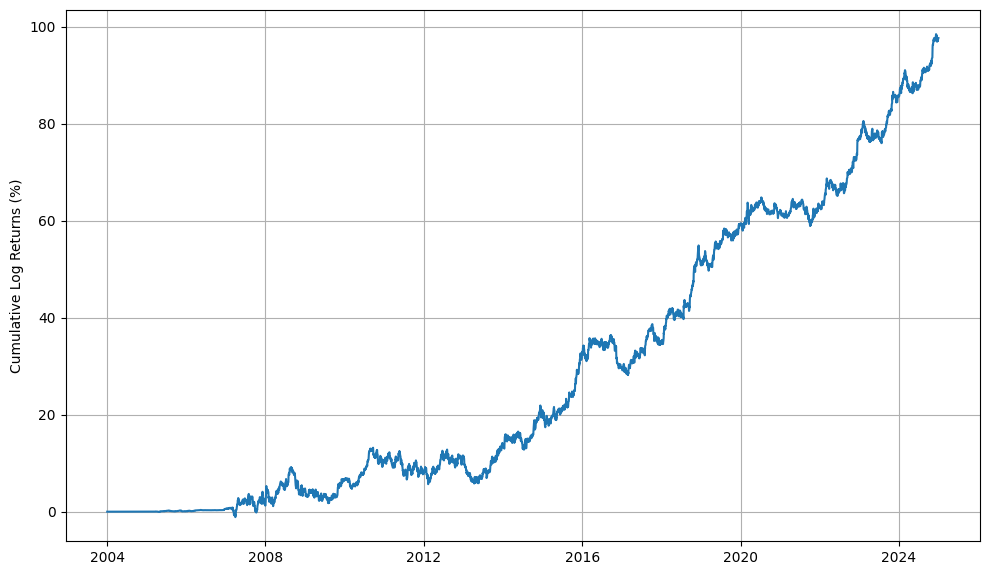

In [5]:
sfp.generate_returns_chart(returns=returns,title='',log_scale=True)


In [6]:
sfp.generate_returns_summary_table(returns=returns)

Count,Mean Return (%),Volatility (%),Total Return (%),Sharpe
u32,f64,f64,f64,f64
5285,4.79,5.13,165.64,0.93


In [7]:
leverage=sfp.generate_leverage_from_weights(weights=weights)
lev_table=sfp.generate_leverage_summary_table(leverage=leverage)
lev_table

Count,Mean Leverage,Min Leverage,Max Leverage,Std Leverage
u32,f64,f64,f64,f64
5285,4.83,0.0,7.67,2.38


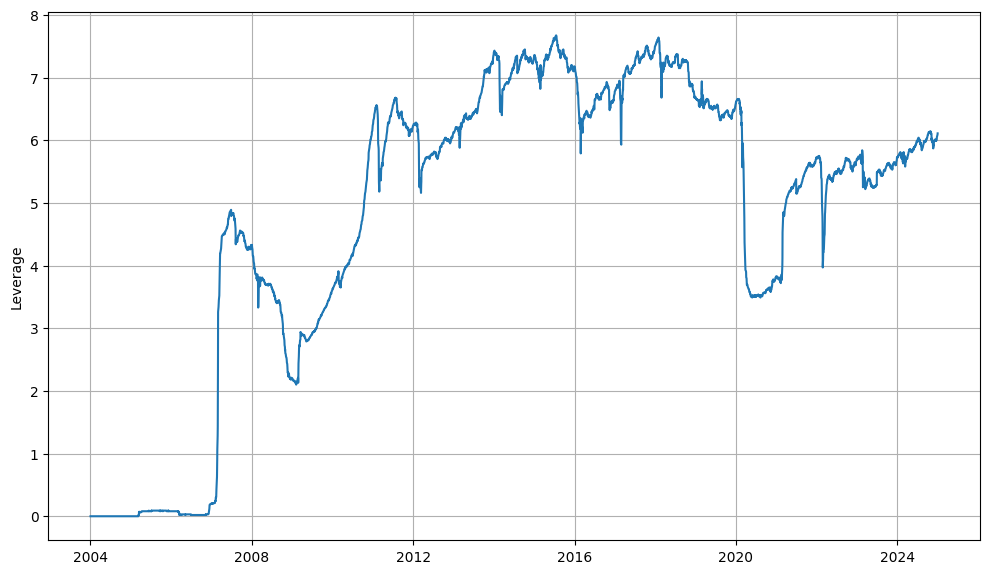

In [8]:
sfp.generate_leverage_chart(leverage=leverage,title='')

In [9]:
drawdown=sfp.generate_drawdown_from_returns(returns=returns)
draw_tbl=sfp.generate_drawdown_summary_table(drawdown=drawdown)
draw_tbl

Count,Mean Drawdown (%),Max Drawdown (%),Current Drawdown (%),Longest Drawdown (days)
u32,f64,f64,f64,i32
5285,-1.96,-7.9,-0.81,809


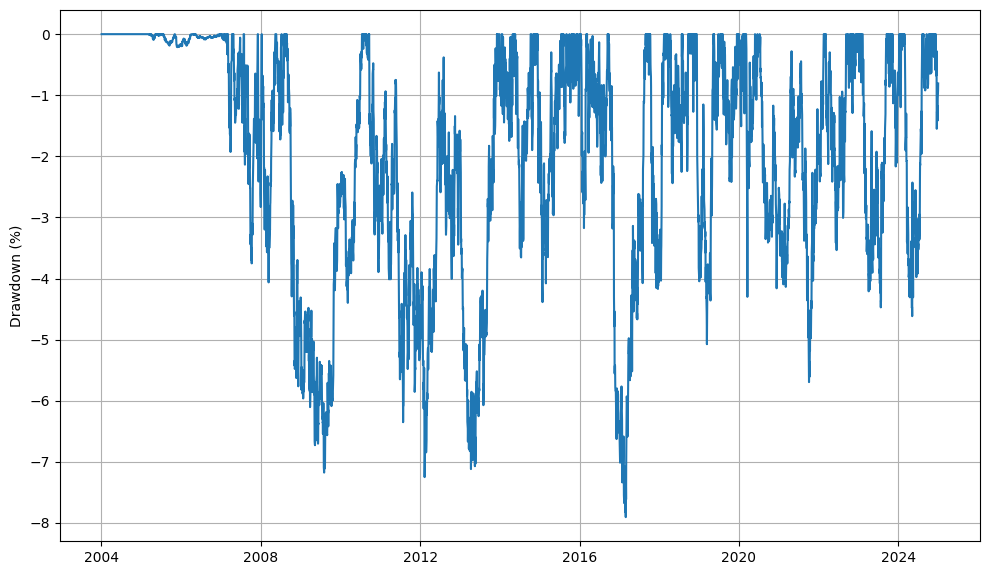

In [10]:
sfp.generate_drawdown_chart(drawdowns=drawdown,title='')

In [11]:
turnover=sfp.get_turnover_stats(weights=weights)
turnover


Mean Turnover,Min Turnover,Max Turnover
f64,f64,f64
0.1411,0.0,0.2502


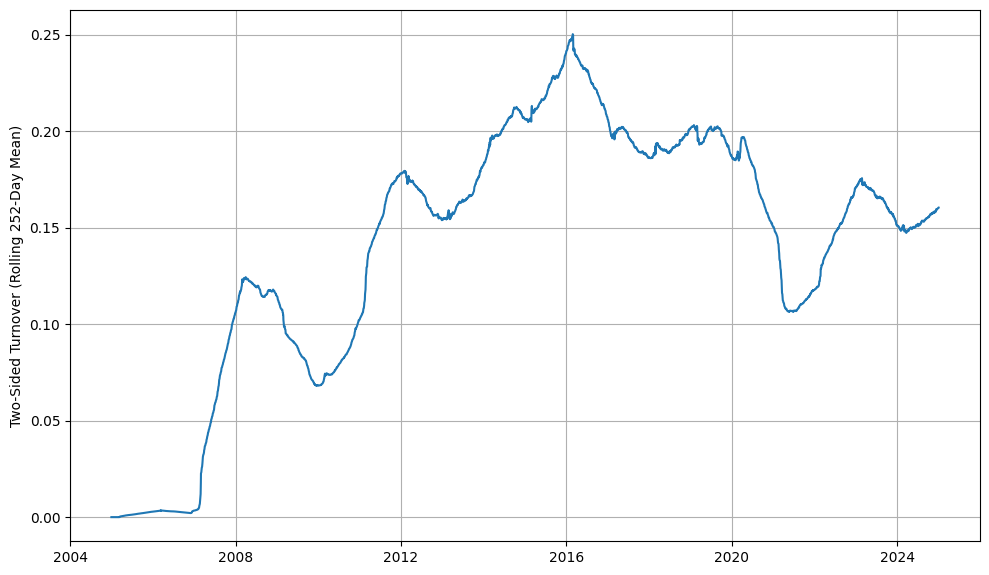

In [12]:
sfp.plot_turnover(weights=weights,title='')

In [13]:
ports=returns

In [14]:
labels_w_spread=['return']

In [15]:
import pandas as pd
import statsmodels.formula.api as smf

ff5=(pl.read_csv(r'/home/porter77/sf_fall_2025/sf-quant-labs/ff5_daily.csv')
    # 1) lowercase all column names
    .rename({c: c.lower() for c in pl.read_csv(r'/home/porter77/sf_fall_2025/sf-quant-labs/ff5_daily.csv').columns})
    # 2) convert YYYYMM -> Date (YYYY-MM-01)
    .with_columns(
        pl.col("date")
        .cast(pl.Utf8)
        .str.strptime(pl.Date, format="%Y%m%d", strict=False)
        .alias("date")
    )
)
#make the month date month end rather than month start
ff5=ff5.with_columns(
    (pl.col('date').dt.month_end()).alias('date')
)

#ff5 uses percentage, need to convert to decimal divide all numeric by 100
ff5 = ff5.with_columns(
    pl.selectors.numeric() / 100
)


ff5_merged=ports.join(ff5,on=['date'],how='inner')
#getting excess return for each port and then making them cols
for bin in labels_w_spread:
    try:
        ff5_merged=ff5_merged.with_columns(
            (pl.col(bin)-pl.col('rf')).alias(f'ex_{bin}')
        )
    except Exception:
        continue

#rename mkt-rf to just mkt
ff5_merged=ff5_merged.rename({'mkt-rf':'mkt'})

ff5_merged_pd=ff5_merged.to_pandas()
ff5_merged_pd = ff5_merged_pd.sort_values('date')

#sort ff5_merged_pd
ff5_merged_pd.sort_values('date')
#now do the ff5 regressions

residuals_dict = {}

results_list = []
for b in labels_w_spread:
    try:
        if b=='spread': # we do not need to use ex_spread because (p4-rf) - (p0-rf), the rf will cancel so we can just do p4-p0
            model = smf.ols(
                formula=f'spread ~ mkt + smb + hml + rmw + cma',
                data=ff5_merged_pd
            )
            res = model.fit()
            results_list.append(res)

            alpha = res.params["Intercept"]
            residuals_dict[b] = res.resid +alpha #adding alpha back in
        else:
            model = smf.ols(
                formula=f'ex_{b} ~ mkt + smb + hml + rmw + cma',
                data=ff5_merged_pd
            )
            res = model.fit()
            results_list.append(res)
            alpha = res.params["Intercept"] 
            residuals_dict[b] = res.resid +alpha #adding the alpha back in
    except Exception:
        continue

#chats code to make it into a reg table
def results_to_df(results_list, col_names=None, params=None, dec_coef=4, dec_t=2):
    if col_names is None:
        col_names = [f"Model {i+1}" for i in range(len(results_list))]

    if params is None:
        params = ["Intercept", "mkt", "smb", "hml", "rmw", "cma"]

    pretty = {
        "mkt": "MKT",
        "smb": "SMB",
        "hml": "HML",
        "rmw": "RMW",
        "cma": "CMA"
    }

    rows = []

    for p in params:
        row = {"Term": pretty.get(p, p)}

        for name, res in zip(col_names, results_list):
            if p in res.params.index:
                coef = res.params[p]
                t = res.tvalues[p]
                row[name] = f"{coef:.{dec_coef}f} ({t:.{dec_t}f})"
            else:
                row[name] = ""

        rows.append(row)

    return pd.DataFrame(rows).set_index("Term")

# Example:
col_names = [f" {b}" for b in labels_w_spread]
tbl = results_to_df(results_list, col_names=col_names)
tbl


,return
Term,
Intercept,0.0003 (6.94)
MKT,-0.0013 (-0.32)
SMB,-0.0079 (-0.99)
HML,0.0066 (0.92)
RMW,-0.0035 (-0.32)
CMA,-0.0102 (-0.70)
